In [1]:
import tensorflow
import keras
print('Keras      :', keras.__version__)
print('Tensorflow :', tensorflow.__version__)

Keras      : 2.1.5
Tensorflow : 1.7.0


Using TensorFlow backend.






# Multiclass-Klassifikation 
## Zweck
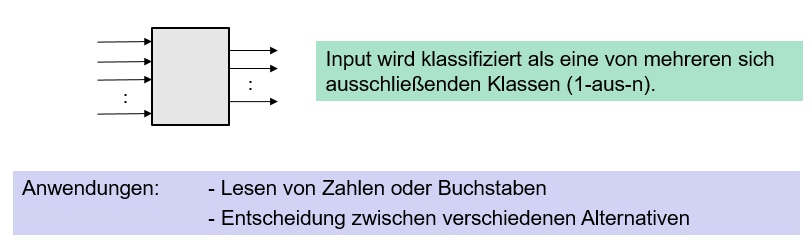

## Beispiel: Lesen handgeschriebener Zahlen 
### Idee
Im folgenden Beispiel sollen handgeschriebene Zahlen (Bildgröße 28x28) klassifiziert werden.
### Daten
Die Daten für das Training und die Validation des Klassifikators, stammen aus dem MNIST-Dataset.  
Die Daten sind wie folgt aufgeteilt: 60.000 Trainingsdaten und 10.000 Testdaten.  
Der MNIST-Datensatz ist im Keras-Paket enthalten.

---



# Es geht los ......
### Laden der benötigten Python-Bibliotheken
<ul>
<li><strong>numpy</strong>: Wissenschaftliches Rechnen mit Python
<li><strong>keras</strong>: Zusatz zu Tensorflow. Die Erstellung und das Training Neuronaler Netze wird dadurch erheblich vereinfacht.
<lu>

In [2]:
# Biliothek: Drucken von Grafiken, Bildern, etc. .....
from matplotlib            import pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

# Bibliothek: Rechnen mit Matrizen, Vektoren, etc. ......
import numpy as np
import keras

from keras                 import backend as K
from keras.models          import Sequential
from keras.datasets        import mnist
from keras.layers          import Dense, Activation, Dropout, Flatten
from keras.utils           import np_utils
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.optimizers      import RMSprop

### Reproduzierbare Versuche
Zufallszahlengenerator (z.B. bei der Initialisierung von NN) immer gleich starten (mit seed()).<br />
Versuche werden dadurch wiederholbar und vergleichbar.

In [3]:
np.random.seed(13)

### MNIST-Datensatz für Training und Test laden

In [4]:
(X_train_ori, y_train_ori), (X_test_ori, y_test_ori) = mnist.load_data()   # MNIST-Datensatz laden

NumClasses         = 10                    # Anzahl der Klassen (MNIST)
ImgRows, ImgCols   = 28, 28                # Format des Input-Fensters (MNIST)
InputSize          = ImgRows * ImgCols     # Größe des Input-Fensters (MNIST)

In [5]:
print('X_train_ori :', X_train_ori.shape)
print('X_test_ori  :', X_test_ori.shape)

X_train_ori : (60000, 28, 28)
X_test_ori  : (10000, 28, 28)


# ============================================================

# Versuch 1: Multilayer-Perzeptron mit einem hidden Layer

### Formatierung der Trainings- und Testdaten für das Multilayer-Perzeptron
Multilayer-Perzeptron bekommt kein 28x28-Bild, sondern einfach nur 784 Inputwerte (= InputSize).

In [6]:
X_train = X_train_ori.reshape(60000, InputSize)
X_test  = X_test_ori.reshape( 10000, InputSize)

In [7]:
print('X_train :', X_train.shape)
print('X_test  :', X_test.shape)

X_train : (60000, 784)
X_test  : (10000, 784)


In [8]:
#  Funktionsdeklaration : Bilder in einem Raster Drucken
def draw_digit(data, row, col, n):
    plt.subplot(row, col, n)    
    plt.imshow(data)
    plt.gray()

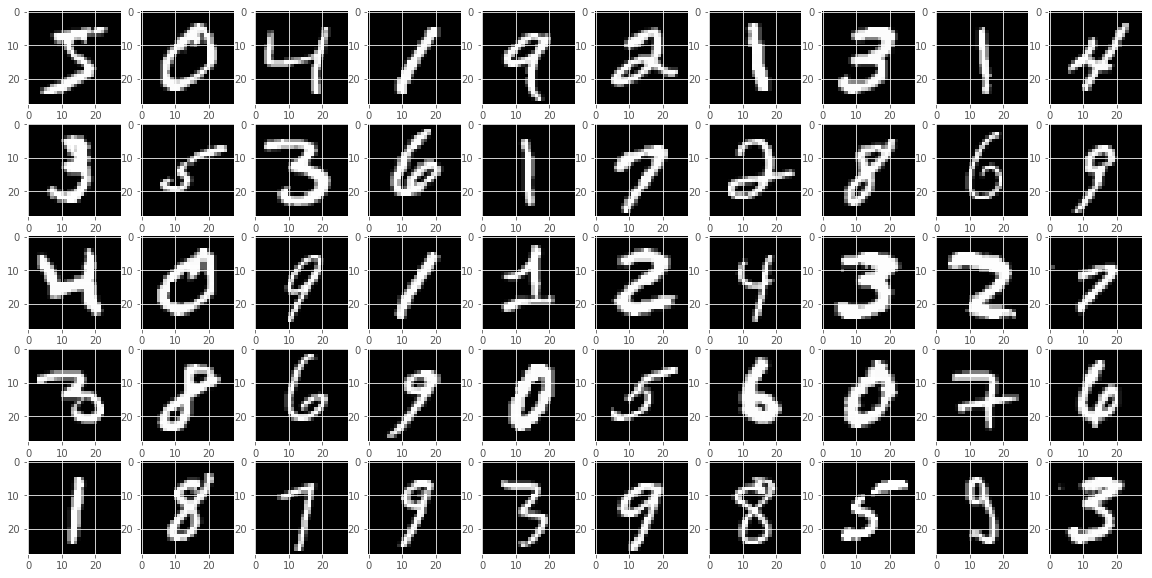

In [9]:
# Eine Auswahl von handgeschriebenen Zeichen in einem Bildraster anzeigen
cols                = 10
rows                = 5
plt.figure(figsize  = (20,10))

for i in range(rows):
    for k in range(cols):
        draw_digit(X_train[i*10+k].reshape(28,28), rows, cols, i*10+k+1)

plt.show()

### Grauwerte der Bilder für das NN aufbereiten

In [10]:
# Bildpunkttyp (Grauwerte = 0 ...255) auf float konvertieren ....
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# ... und auf den Wertebereich 0...1 transformieren
X_train /= 255
X_test  /= 255

print('X_train :', X_train.shape)
print('X_test  :', X_test.shape)

X_train : (60000, 784)
X_test  : (10000, 784)


### Ergebnisse der Trainings- und Testdaten aufbereiten

Die Ergebnisse (Klassen der Bilder) liegen im Datensatz als Integerzahl vor (z.B. 7) wenn eine 7 abgebildet ist.<br />
Benötigt werden aber die Outputs des NN, also z.B. [0 0 0 0 0 0 0 1 0 0] für die abgebildete 7 (= One-hot-Encoding). 

Zu diesem Zweck müssen die Outputklassen konvertiert werden.

In [11]:
print(y_train_ori.shape)
print(y_train_ori[:5])

(60000,)
[5 0 4 1 9]


In [12]:
# Zahlenwert der Outputklasse konvertieren in 10-dim. Outputvektor transformieren (to_categorical-Methode)
Y_train = np_utils.to_categorical(y_train_ori, 10)
Y_test  = np_utils.to_categorical(y_test_ori,  10)

print(Y_train.shape)
print()
print(y_train_ori[:5])
print()
print(Y_train[:5])

(60000, 10)

[5 0 4 1 9]

[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


### Beschreibung des gewünschten Neuronalen Netzes
Mit model.add() wird Schicht für Schicht des NN beschrieben.
<ul>
<li><strong>Dense</strong>: Einfacher Fully-connected-Layer.
<li><strong>sigmoid</strong>: Logistische Aktivierrungsfunktion (Alternativen: tanh, relu, ....).
<li><strong>glorot_uniform</strong>: Methode zur zufälligen Gewichtsinitialisierung.
</ul>

Der letzte Layer ist als *softmax-Layer* ausgelegt. Die Summe der Ausgabewerte ist somit 1.

In [13]:
# ----------------------------------------------------
# Netz 1: - Multilayer-Perzeptron mit einem Hidden-Layer
#         - Logistische Aktivierungsfunktion
# ----------------------------------------------------


# ------------------------------------------------------------------------------------------
# Beschreibung des Netzes, Layer für Layer.
# ------------------------------------------------------------------------------------------
model = Sequential()

# 1. Hidden Layer:  Fully connected mit ReLu-Aktivierungsfunktion
model.add(Dense(units = 200,   kernel_initializer="glorot_uniform",   input_shape=(InputSize,)))
model.add(Activation("sigmoid"))


# Output Layer:  Fully connected mit Softmax-Aktivierungsfunktion
model.add(Dense(NumClasses,  kernel_initializer="glorot_uniform"))
model.add(Activation('softmax'))

# ------------------------------------------------------------------------------------------

In [14]:
# Übersicht über das NN und die Parameter
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               157000    
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2010      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
_________________________________________________________________


### Konfiguration des Lernprozesses
Gute Erklärungen zu den Parametern sind hier zu finden:  ([link](http://ruder.io/optimizing-gradient-descent/index.html#rmsprop))

In [15]:
model.compile(loss      = 'categorical_crossentropy',     # categorical_crossentropy, mse
              optimizer = 'rmsprop',     # adam, rmsprop
              metrics   = ['accuracy'])

### Training des NN

In [16]:
# Training
history = model.fit(X_train, Y_train,
                  batch_size      =  32,    # Minibatch-Größe
                  epochs          =  10,    # Anzahl der Trainingsepochen (ohne GPU nicht übertreiben)
                  verbose         =  1,     # Informationen anzeigen
                  validation_data =  (X_test, Y_test))


score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:    ', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.3517 - acc: 0.9041 - val_loss: 0.2115 - val_acc: 0.9371
Epoch 2/10
60000/60000 [==============================] - 5s 81us/step - loss: 0.1839 - acc: 0.9461 - val_loss: 0.1489 - val_acc: 0.9530
Epoch 3/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.1362 - acc: 0.9603 - val_loss: 0.1271 - val_acc: 0.9604
Epoch 4/10
60000/60000 [==============================] - 5s 80us/step - loss: 0.1085 - acc: 0.9683 - val_loss: 0.1093 - val_acc: 0.9666
Epoch 5/10
60000/60000 [==============================] - 5s 81us/step - loss: 0.0899 - acc: 0.9730 - val_loss: 0.0960 - val_acc: 0.9717
Epoch 6/10
60000/60000 [==============================] - 5s 82us/step - loss: 0.0766 - acc: 0.9772 - val_loss: 0.0969 - val_acc: 0.9720
Epoch 7/10
60000/60000 [==============================] - 5s 81us/step - loss: 0.0668 - acc: 0.9809 - val_loss: 0.0862 - val_ac

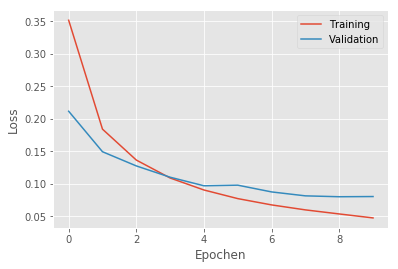

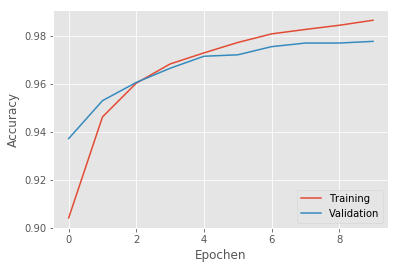

In [17]:
plt.figure(0)

plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(1)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

============================================================================================================
# !!! Aufgaben

a) Berechnen Sie selber die Anzahl der Parameter.

b) Modifizieren Sie das NN (relu, adam, Trainingsepochen, Neuronenzahl, ...) mit dem Ziel, eine Validation-Accuracy von ** ca 98% ** zu erreichen.  

**Wichtig: ** Die Zahl der Layer soll dabei nicht erhöht werden. 

### Dokumentieren Sie mind. 3 Versuchsvarianten 
* Parameter 
* Val.-Accuracy 
* graph. Traingsverläufe 

============================================================================================================

## Erste Versuchsvariante
* mit loss = mse

In [50]:
model = Sequential()

# 1. Hidden Layer:  Fully connected mit ReLu-Aktivierungsfunktion
model.add(Dense(units = 200,   kernel_initializer="glorot_uniform",   input_shape=(InputSize,)))
model.add(Activation("sigmoid"))


# Output Layer:  Fully connected mit Softmax-Aktivierungsfunktion
model.add(Dense(NumClasses,  kernel_initializer="glorot_uniform"))
model.add(Activation('softmax'))

In [51]:
model.compile(loss      = 'mse',     # categorical_crossentropy, mse BENUTZEN MSE statt categorical_crossentropy
              optimizer = 'rmsprop',     # adam, rmsprop : 
              metrics   = ['accuracy'])

In [52]:
# Training
history = model.fit(X_train, Y_train,
                  batch_size      =  32,    # Minibatch-Größe
                  epochs          =  10,    # Anzahl der Trainingsepochen (ohne GPU nicht übertreiben)
                  verbose         =  1,     # Informationen anzeigen
                  validation_data =  (X_test, Y_test))


score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:    ', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 85us/step - loss: 0.0159 - acc: 0.9006 - val_loss: 0.0097 - val_acc: 0.9364
Epoch 2/10
60000/60000 [==============================] - 5s 78us/step - loss: 0.0087 - acc: 0.9441 - val_loss: 0.0075 - val_acc: 0.9527
Epoch 3/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.0067 - acc: 0.9571 - val_loss: 0.0063 - val_acc: 0.9579
Epoch 4/10
60000/60000 [==============================] - 5s 84us/step - loss: 0.0054 - acc: 0.9652 - val_loss: 0.0054 - val_acc: 0.9659
Epoch 5/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.0046 - acc: 0.9714 - val_loss: 0.0050 - val_acc: 0.9681
Epoch 6/10
60000/60000 [==============================] - 5s 78us/step - loss: 0.0039 - acc: 0.9756 - val_loss: 0.0044 - val_acc: 0.9718
Epoch 7/10
60000/60000 [==============================] - 5s 82us/step - loss: 0.0034 - acc: 0.9790 - val_loss: 0.0041 - val_acc

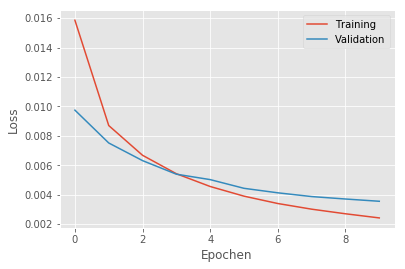

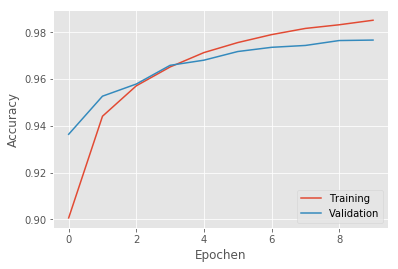

In [53]:
plt.figure(0)

plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(1)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

In [31]:
input_anzahl = 28 * 28 * 200 + 200    # input_shape mal Neuronen vom 1ten Layer plus Neuronen vom 1tes Layer
param_anzahl1 = 200 * 10 + 10       # Neuronen vom erten Layer mal Neuronen vom 2ten Layer plus Neuronen vom zweiten Layer       # Neuronen vom 3ten Layer mal Neuronen vom output Layer plus Neuronen vom output Layer
param_anzahl_gesamt = input_anzahl + param_anzahl1
print('Von Hand berechnet: ',param_anzahl_gesamt)

Von Hand berechnet:  159010


## Zweite Versuchsvariante
* optimizer = 'adam'

In [46]:
model = Sequential()

# 1. Hidden Layer:  Fully connected mit ReLu-Aktivierungsfunktion
model.add(Dense(units = 200,   kernel_initializer="glorot_uniform",   input_shape=(InputSize,)))
model.add(Activation("sigmoid"))


# Output Layer:  Fully connected mit Softmax-Aktivierungsfunktion
model.add(Dense(NumClasses,  kernel_initializer="glorot_uniform"))
model.add(Activation('softmax'))

In [47]:
model.compile(loss      = 'categorical_crossentropy',     # categorical_crossentropy, mse
              optimizer = 'adam',     # adam, rmsprop : BENUTZEN ADAM statt RMSPROP um ca 98% zu erreichen
              metrics   = ['accuracy'])

In [48]:
# Training
history = model.fit(X_train, Y_train,
                  batch_size      =  32,    # Minibatch-Größe
                  epochs          =  10,    # Anzahl der Trainingsepochen (ohne GPU nicht übertreiben)
                  verbose         =  1,     # Informationen anzeigen
                  validation_data =  (X_test, Y_test))


score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:    ', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 93us/step - loss: 0.3682 - acc: 0.8999 - val_loss: 0.2220 - val_acc: 0.9371
Epoch 2/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.1865 - acc: 0.9456 - val_loss: 0.1670 - val_acc: 0.9496
Epoch 3/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.1335 - acc: 0.9616 - val_loss: 0.1265 - val_acc: 0.9619
Epoch 4/10
60000/60000 [==============================] - 5s 89us/step - loss: 0.1017 - acc: 0.9706 - val_loss: 0.1021 - val_acc: 0.9690
Epoch 5/10
60000/60000 [==============================] - 5s 90us/step - loss: 0.0786 - acc: 0.9776 - val_loss: 0.0898 - val_acc: 0.9719
Epoch 6/10
60000/60000 [==============================] - 5s 91us/step - loss: 0.0625 - acc: 0.9824 - val_loss: 0.0799 - val_acc: 0.9744
Epoch 7/10
60000/60000 [==============================] - 5s 91us/step - loss: 0.0506 - acc: 0.9854 - val_loss: 0.0756 - val_acc

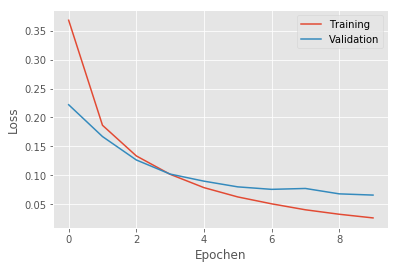

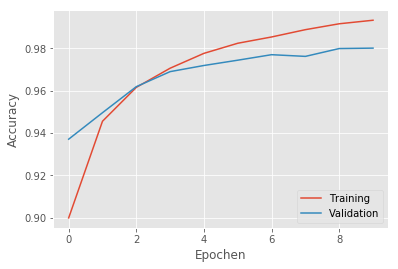

In [49]:
plt.figure(0)

plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(1)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

## Dritte Versuchsvariante
* optimizer = 'adam' und
* loss      = 'mse'

In [24]:
model = Sequential()

# 1. Hidden Layer:  Fully connected mit ReLu-Aktivierungsfunktion
model.add(Dense(units = 200,   kernel_initializer="glorot_uniform",   input_shape=(InputSize,)))
model.add(Activation("sigmoid"))


# Output Layer:  Fully connected mit Softmax-Aktivierungsfunktion
model.add(Dense(NumClasses,  kernel_initializer="glorot_uniform"))
model.add(Activation('softmax'))

In [25]:
model.compile(loss      = 'mse',     # categorical_crossentropy, mse
              optimizer = 'adam',     # adam, rmsprop : BENUTZEN ADAM statt RMSPROP um ca 98% zu erreichen
              metrics   = ['accuracy'])

In [26]:
# Training
history = model.fit(X_train, Y_train,
                  batch_size      =  32,    # Minibatch-Größe
                  epochs          =  10,    # Anzahl der Trainingsepochen (ohne GPU nicht übertreiben)
                  verbose         =  1,     # Informationen anzeigen
                  validation_data =  (X_test, Y_test))


score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:    ', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 91us/step - loss: 0.0161 - acc: 0.8994 - val_loss: 0.0097 - val_acc: 0.9385
Epoch 2/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0085 - acc: 0.9463 - val_loss: 0.0075 - val_acc: 0.9525
Epoch 3/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0064 - acc: 0.9591 - val_loss: 0.0058 - val_acc: 0.9639
Epoch 4/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0050 - acc: 0.9689 - val_loss: 0.0051 - val_acc: 0.9672
Epoch 5/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0041 - acc: 0.9755 - val_loss: 0.0047 - val_acc: 0.9693
Epoch 6/10
60000/60000 [==============================] - 5s 87us/step - loss: 0.0034 - acc: 0.9796 - val_loss: 0.0043 - val_acc: 0.9722
Epoch 7/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.0029 - acc: 0.9834 - val_loss: 0.0044 - val_acc

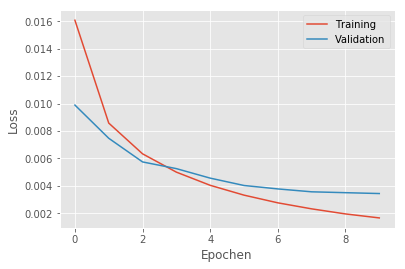

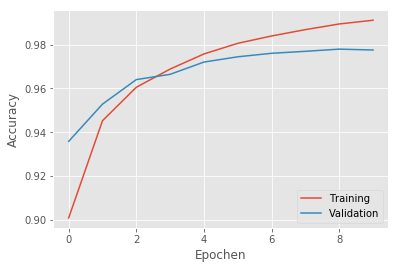

In [57]:
plt.figure(0)

plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(1)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

### Fehleranalyse
1. Anzeigen einiger Fehlklassifikationen
2. Confusion-Matrix (= wer wird mit wem verwechselt?)

In [18]:
# Die erkannten Klassen der Testdaten bestimmen.
predicted_classes = model.predict_classes(X_test)

# Die Indices der richtig und falsch erkannten Muster bestimmen
correct   = np.nonzero(predicted_classes == y_test_ori)[0]     # nonzero:  Return the indices of array-
incorrect = np.nonzero(predicted_classes != y_test_ori)[0]     #           elements that are non-zero

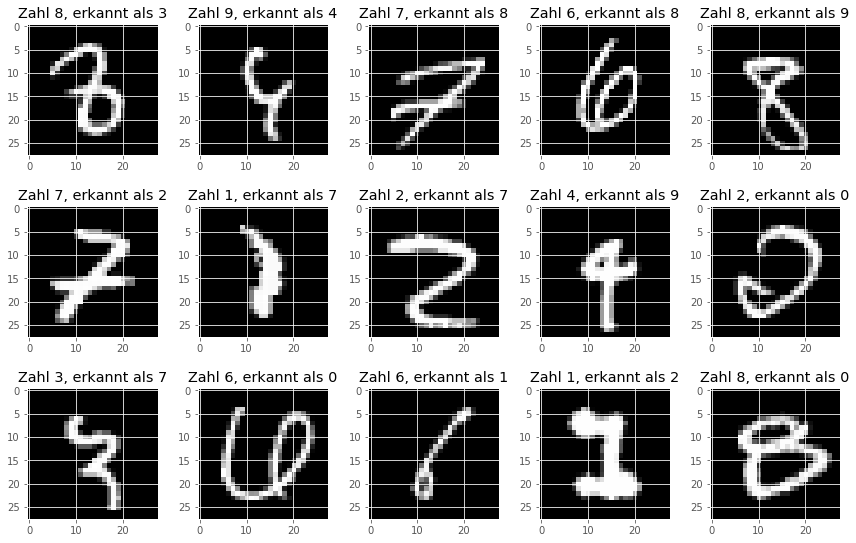

In [19]:
start                = 60    # Startindex

plt.figure(2)
plt.figure(figsize   = (12,8))
           
for i, incorr in enumerate(incorrect[start:start+15]):
    #print(i, incorr)
    plt.subplot(3,5,i+1)
    plt.imshow(X_test[incorr].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Zahl {}, erkannt als {}".format(y_test_ori[incorr], predicted_classes[incorr]))
    plt.tight_layout()

In [20]:
# Die Confusion-Matrix zeigt an, wie oft ein Zeichen
# für ein anderes Zeichen gehalten wird.
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test_ori, predicted_classes))

[[ 971    0    2    2    0    1    2    1    1    0]
 [   0 1119    5    1    0    1    2    2    5    0]
 [   4    0 1010    1    2    0    2    7    6    0]
 [   0    0    7  980    0   10    0    7    3    3]
 [   1    0    4    1  964    0    3    2    1    6]
 [   2    0    0    3    1  879    3    2    1    1]
 [   7    3    0    0    4   12  927    0    5    0]
 [   0    3   10    2    1    0    0 1008    2    2]
 [   4    0    6    5    4    5    2    5  939    4]
 [   1    2    0    7   10    2    1    7    0  979]]


# ==============================================================

# Versuch 2: Multilayer-Perzeptron erweitert

In [17]:
# -------------------------------------------------
# Netz 2: - Multilayer-Perzeptron mit 2 (oder mehr) Hidden-Layern
#         - ReLu-Aktivierungsfunktion
#         - Dropout-Layer
# -------------------------------------------------


# ------------------------------------------------------------------------------------------
# Beschreibung des Netzes, Layer für Layer.
# ------------------------------------------------------------------------------------------
model = Sequential()

model.add(Dense(units = 300,  kernel_initializer="glorot_uniform", input_shape=(InputSize,)))
model.add(Activation('relu'))

model.add(Dropout(0.3))

model.add(Dense(units = 200, kernel_initializer="glorot_uniform"))
model.add(Activation('relu'))

model.add(Dropout(0.3))

model.add(Dense(NumClasses, kernel_initializer="glorot_uniform"))   # Der letzte Layer hat ein Output pro Klasse.
model.add(Activation('softmax')) 
 
    
    
# Übersicht über das NN und die Parameter
model.summary()
  
    
    
# Konfiguration des Trainings
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=["accuracy"])
 
    
    
# Durchführung des Trainings
hist2= model.fit(X_train, Y_train,
                batch_size = 32, 
                epochs     = 10,
                verbose    = 1,
                validation_data = (X_test, Y_test))



# Endergebnis berechnen und ausgeben
score = model.evaluate(X_test, Y_test, verbose=0)
print()
print('Test score:   ', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
activation_3 (Activation)    (None, 300)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               60200     
_________________________________________________________________
activation_4 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2010      
__________

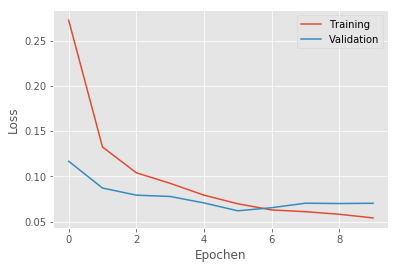

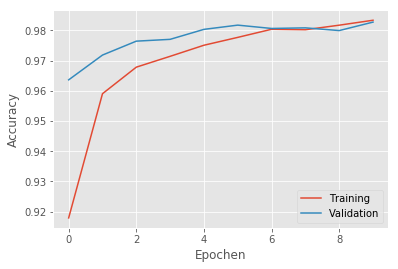

In [18]:
plt.figure(3)
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(4)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(hist2.history['acc'])
plt.plot(hist2.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

============================================================================================================
# !!! Aufgaben

a) Berechnen Sie selber die Anzahl der Parameter.

b) Modifizieren Sie das NN (Trainingsepochen, Neuronenzahl, Dropout, mehr Layer, ...) mit dem Ziel, eine Validation-Accuracy von ** ca. 98% ** zu erreichen.  
 

### Dokumentieren Sie mind. 3 Versuchsvarianten 
* Parameter 
* Val.-Accuracy 
* graph. Traingsverläufe 

============================================================================================================

In [19]:
input_anzahl = 28 * 28 * 300 + 300    # input_shape mal Neuronen vom 1ten Layer plus Neuronen vom 1tes Layer
param_anzahl1 = 300 * 200 + 200       # Neuronen vom erten Layer mal Neuronen vom 2ten Layer plus Neuronen vom zweiten Layer       # Neuronen vom 3ten Layer mal Neuronen vom output Layer plus Neuronen vom output Layer
param_anzahl2 = 200 * 10 + 10       # Neuronen vom erten Layer mal Neuronen vom 2ten Layer plus Neuronen vom zweiten Layer       # Neuronen vom 3ten Layer mal Neuronen vom output Layer plus Neuronen vom output Layer

param_anzahl_gesamt = input_anzahl + param_anzahl1 + param_anzahl2
print('Von Hand berechnet: ',param_anzahl_gesamt)

Von Hand berechnet:  297710


## Erste Versuchsvariante
* loss      = 'mse'

In [20]:
# -------------------------------------------------
# Netz 2: - Multilayer-Perzeptron mit 2 (oder mehr) Hidden-Layern
#         - ReLu-Aktivierungsfunktion
#         - Dropout-Layer
# -------------------------------------------------


# ------------------------------------------------------------------------------------------
# Beschreibung des Netzes, Layer für Layer.
# ------------------------------------------------------------------------------------------
model = Sequential()

model.add(Dense(units = 300,  kernel_initializer="glorot_uniform", input_shape=(InputSize,)))
model.add(Activation('relu'))

model.add(Dropout(0.3))

model.add(Dense(units = 200, kernel_initializer="glorot_uniform"))
model.add(Activation('relu'))

model.add(Dropout(0.3))

model.add(Dense(NumClasses, kernel_initializer="glorot_uniform"))   # Der letzte Layer hat ein Output pro Klasse.
model.add(Activation('softmax')) 
 
    
    
# Übersicht über das NN und die Parameter
model.summary()
  
    
    
# Konfiguration des Trainings
model.compile(loss      = 'mse',     # categorical_crossentropy, mse
              optimizer = 'adam',     # adam, rmsprop : BENUTZEN ADAM statt RMSPROP um ca 98% zu erreichen
              metrics   = ['accuracy'])
    
    
# Durchführung des Trainings
hist2= model.fit(X_train, Y_train,
                batch_size = 32, 
                epochs     = 10,
                verbose    = 1,
                validation_data = (X_test, Y_test))



# Endergebnis berechnen und ausgeben
score = model.evaluate(X_test, Y_test, verbose=0)
print()
print('Test score:   ', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 300)               235500    
_________________________________________________________________
activation_6 (Activation)    (None, 300)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 200)               60200     
_________________________________________________________________
activation_7 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                2010      
__________

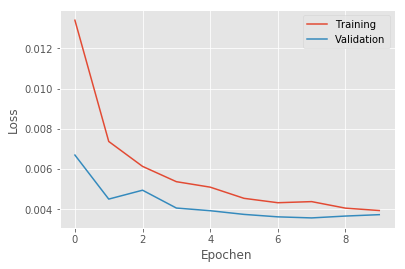

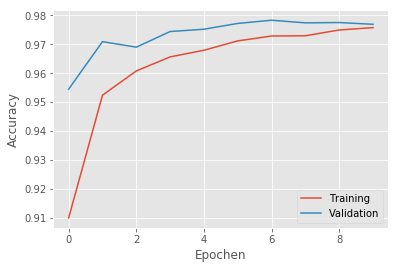

In [21]:
plt.figure(3)
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(4)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(hist2.history['acc'])
plt.plot(hist2.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

## Zweiter Versuchsvariante
* Dropout = 0.5

In [22]:
# -------------------------------------------------
# Netz 2: - Multilayer-Perzeptron mit 2 (oder mehr) Hidden-Layern
#         - ReLu-Aktivierungsfunktion
#         - Dropout-Layer
# -------------------------------------------------


# ------------------------------------------------------------------------------------------
# Beschreibung des Netzes, Layer für Layer.
# ------------------------------------------------------------------------------------------
model = Sequential()

model.add(Dense(units = 300,  kernel_initializer="glorot_uniform", input_shape=(InputSize,)))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(units = 200, kernel_initializer="glorot_uniform"))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(NumClasses, kernel_initializer="glorot_uniform"))   # Der letzte Layer hat ein Output pro Klasse.
model.add(Activation('softmax')) 
 
    
    
# Übersicht über das NN und die Parameter
model.summary()
  
    
    
# Konfiguration des Trainings
model.compile(loss      = 'categorical_crossentropy',     # categorical_crossentropy, mse
              optimizer = 'adam',     # adam, rmsprop : BENUTZEN ADAM statt RMSPROP um ca 98% zu erreichen
              metrics   = ['accuracy'])
    
    
# Durchführung des Trainings
hist2= model.fit(X_train, Y_train,
                batch_size = 32, 
                epochs     = 10,
                verbose    = 1,
                validation_data = (X_test, Y_test))



# Endergebnis berechnen und ausgeben
score = model.evaluate(X_test, Y_test, verbose=0)
print()
print('Test score:   ', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 300)               235500    
_________________________________________________________________
activation_9 (Activation)    (None, 300)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 200)               60200     
_________________________________________________________________
activation_10 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                2010      
__________

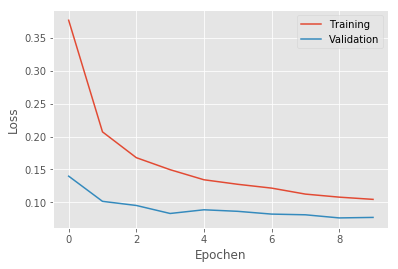

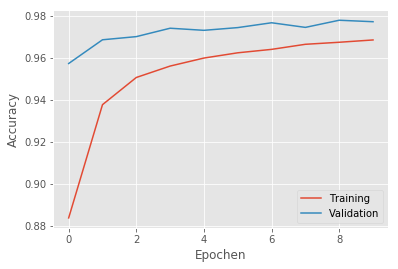

In [23]:
plt.figure(3)
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(4)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(hist2.history['acc'])
plt.plot(hist2.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

## Dritter Versuchsvariante
* optimizer = 'rmsprop'

In [27]:
# -------------------------------------------------
# Netz 2: - Multilayer-Perzeptron mit 2 (oder mehr) Hidden-Layern
#         - ReLu-Aktivierungsfunktion
#         - Dropout-Layer
# -------------------------------------------------


# ------------------------------------------------------------------------------------------
# Beschreibung des Netzes, Layer für Layer.
# ------------------------------------------------------------------------------------------
model = Sequential()

model.add(Dense(units = 300,  kernel_initializer="glorot_uniform", input_shape=(InputSize,)))
model.add(Activation('relu'))

model.add(Dropout(0.3))

model.add(Dense(units = 200, kernel_initializer="glorot_uniform"))
model.add(Activation('relu'))

model.add(Dropout(0.3))

model.add(Dense(NumClasses, kernel_initializer="glorot_uniform"))   # Der letzte Layer hat ein Output pro Klasse.
model.add(Activation('softmax')) 
 
    
    
# Übersicht über das NN und die Parameter
model.summary()
  
    
    
# Konfiguration des Trainings
model.compile(loss      = 'categorical_crossentropy',     # categorical_crossentropy, mse
              optimizer = 'rmsprop',     # adam, rmsprop : BENUTZEN ADAM statt RMSPROP um ca 98% zu erreichen
              metrics   = ['accuracy'])
    
    
# Durchführung des Trainings
hist2= model.fit(X_train, Y_train,
                batch_size = 32, 
                epochs     = 10,
                verbose    = 1,
                validation_data = (X_test, Y_test))



# Endergebnis berechnen und ausgeben
score = model.evaluate(X_test, Y_test, verbose=0)
print()
print('Test score:   ', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 300)               235500    
_________________________________________________________________
activation_14 (Activation)   (None, 300)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 200)               60200     
_________________________________________________________________
activation_15 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                2010      
__________

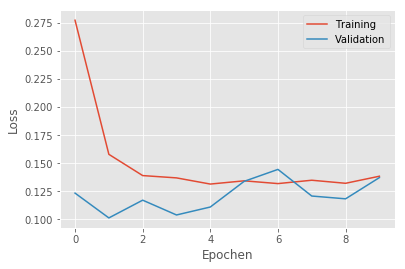

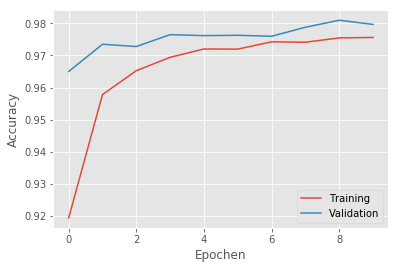

In [28]:
plt.figure(3)
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(4)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(hist2.history['acc'])
plt.plot(hist2.history['val_acc'])
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

### Fehleranalyse
1. Anzeigen einiger Fehlklassifikationen
2. Confusion-Matrix (= wer wird mit wem verwechselt?)

In [59]:
# Die erkannten Klassen der Testdaten bestimmen.
predicted_classes = model.predict_classes(X_test)

# Die Indices der richtig und falsch erkannten Muster bestimmen
correct   = np.nonzero(predicted_classes == y_test_ori)[0]     # nonzero:  Return the indices of array-
incorrect = np.nonzero(predicted_classes != y_test_ori)[0]     #           elements that are non-zero

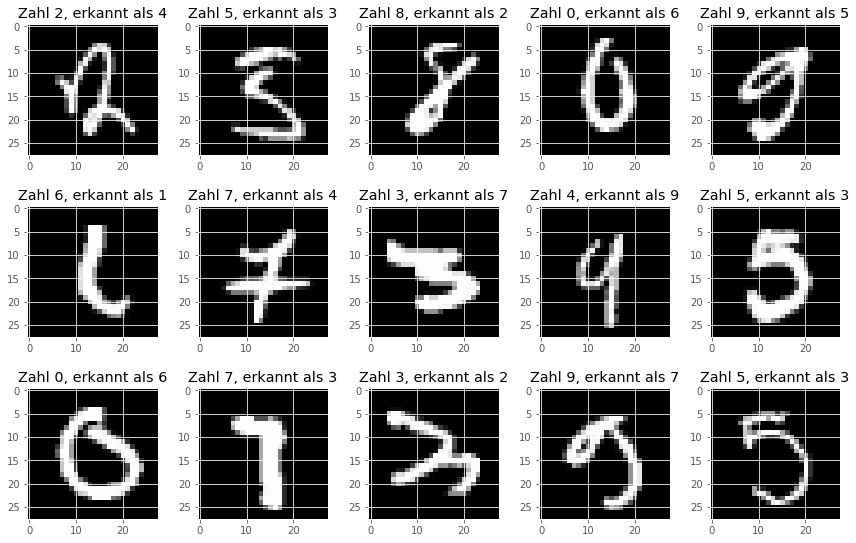

In [24]:
start                = 60    # Startindex

plt.figure(5)
plt.figure(figsize   = (12,8))
           
for i, incorr in enumerate(incorrect[start:start+15]):
    #print(i, incorr)
    plt.subplot(3,5,i+1)
    plt.imshow(X_test[incorr].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Zahl {}, erkannt als {}".format(y_test_ori[incorr], predicted_classes[incorr]))
    plt.tight_layout()

In [25]:
# Die Confusion-Matrix zeigt an, wie oft ein Zeichen
# für ein anderes Zeichen gehalten wird.
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test_ori, predicted_classes))

[[ 964    1    0    2    0    1    8    0    1    3]
 [   0 1129    1    1    0    1    1    0    2    0]
 [   2    1 1013    4    1    0    1    4    6    0]
 [   0    0    2  998    0    0    0    5    4    1]
 [   0    1    3    0  963    1    4    1    0    9]
 [   2    0    0   13    1  870    1    1    3    1]
 [   1    2    0    1    2    3  949    0    0    0]
 [   1    4    6    5    1    0    0 1005    1    5]
 [   0    0    3    4    5    6    4    4  947    1]
 [   0    3    1    5    9    2    0    2    6  981]]


# ==============================================================

# Versuch 3: Kleines Faltungsnetzwerk (CNN)

### Einige zusätzliche Bibliotheken werden benötigt.

In [43]:
from keras.layers.convolutional import Conv2D
from keras.layers.pooling       import MaxPooling2D
from keras.utils                import np_utils
from keras.optimizers           import SGD

### Für Faltungsnetzwerke müssen die Bilddaten etwas anders aufbereitet werden (2-dimensional).

In [44]:
if K.image_data_format() == 'channels_first':
    shape_ord = (1, img_rows, img_cols)
else:  # channel_last
    shape_ord = (ImgRows, ImgRows, 1)
    
print(shape_ord)

(28, 28, 1)


In [45]:
# ....
X_train = X_train_ori.reshape((X_train.shape[0],) + shape_ord)
X_test  = X_test_ori.reshape((X_test.shape[0],)   + shape_ord)

# Bildpunkttyp auf float konvertieren ....
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# ... und auf Wertebereich 0...1 transformieren
X_train /= 255
X_test  /= 255

print('X_train :', X_train.shape)
print('X_test  :', X_test.shape)

X_train : (60000, 28, 28, 1)
X_test  : (10000, 28, 28, 1)


In [59]:
# ------------------------------------------------------------
# Netz 3: - Convolutional_NN mit 3 Conv-Layern + 2 Dense-Layern
#         - ReLu-Aktivierungsfunktion
#         - Dropout-Layer
# ------------------------------------------------------------

model = Sequential()

# -----------------------------------------------------------------------------------------
# Feature-Extractor
# -----------------------------------------------------------------------------------------
model.add(Conv2D(filters=32,      
                 kernel_size=(3, 3),   # alt kernel_size=(5, 5)
                 padding='valid', 
                 input_shape = shape_ord))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.4))


model.add(Conv2D(filters=64, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.4))


model.add(Conv2D(filters=128, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.6))

    
model.add(Flatten())

# -----------------------------------------------------------------------------------------
# Classifier
# -----------------------------------------------------------------------------------------

model.add(Dense(units=128))
model.add(Activation('relu'))

model.add(Dropout(0.7))

model.add(Dense(units=10))
model.add(Activation('softmax'))

In [33]:
# Übersicht über das Faltungsnetzwerk und die Parameter
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_17 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
activation_18 (Activation)   (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
__________

In [60]:
model.compile(loss     =  'categorical_crossentropy',
              optimizer=  'adam',
              metrics  =  ['accuracy'])



hist3 = model.fit(X_train, Y_train, 
                  batch_size = 32, 
                  epochs     = 10,   # ohne GPU nicht mehr als 4, sonst wartet man seeehr lange.
                  verbose    = 1,
                  validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 11s 177us/step - loss: 0.8051 - acc: 0.7359 - val_loss: 0.1248 - val_acc: 0.9627
Epoch 2/10
60000/60000 [==============================] - 10s 163us/step - loss: 0.3361 - acc: 0.9062 - val_loss: 0.0923 - val_acc: 0.9722
Epoch 3/10
60000/60000 [==============================] - 10s 164us/step - loss: 0.2694 - acc: 0.9274 - val_loss: 0.0770 - val_acc: 0.9774
Epoch 4/10
60000/60000 [==============================] - 10s 164us/step - loss: 0.2423 - acc: 0.9358 - val_loss: 0.0636 - val_acc: 0.9809
Epoch 5/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.2214 - acc: 0.9420 - val_loss: 0.0655 - val_acc: 0.9811
Epoch 6/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.2096 - acc: 0.9432 - val_loss: 0.0638 - val_acc: 0.9821
Epoch 7/10
60000/60000 [==============================] - 10s 163us/step - loss: 0.2013 - acc: 0.9458 - val_loss: 0.

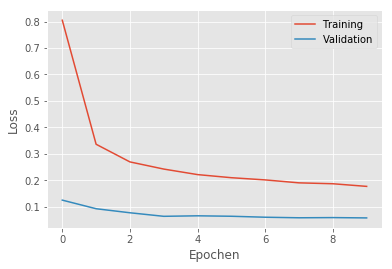

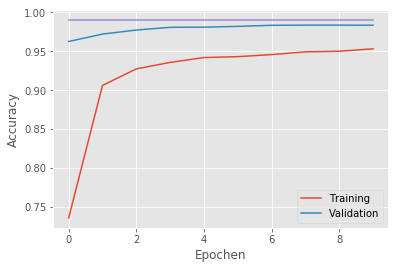

In [61]:
plt.figure(6)
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(7)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(hist3.history['acc'])
plt.plot(hist3.history['val_acc'])
prozent = np.full(10,0.99)
plt.plot(prozent)
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

============================================================================================================
# !!! Aufgaben

a) Berechnen Sie selber die Anzahl der Parameter.

b) Modifizieren Sie das NN (Trainingsepochen, Neuronenzahl, Dropout, kernel_size, ...) mit dem Ziel, eine Validation-Accuracy von ** ca. 99% ** zu erreichen.  
 

### Dokumentieren Sie mind. 3 Versuchsvarianten 
* Parameter 
* Val.-Accuracy 
* graph. Traingsverläufe

============================================================================================================

In [39]:
# (n * m * l + 1) * k: n*m = Faltungsmatrix, l=Inputfilter, 1=Bios, k=Outputfilter
param_anzahl1 = (3 * 3 * 1 + 1) * 32    
param_anzahl2 = (3 * 3 * 32 + 1) * 64  
param_anzahl3 = (3 * 3 * 64 + 1) * 128        

param_anzahl4 = 128 * 128 + 128
param_anzahl5 = 128 * 10 + 10

param_anzahl_gesamt = param_anzahl1 + param_anzahl2 + param_anzahl3 + param_anzahl4 + param_anzahl5
print('Von Hand berechnet: ',param_anzahl_gesamt)

Von Hand berechnet:  110474


# Versuchvariante 1
* Kernelgröße von erten und zweiten ConvLayer auf 5 mal 5 gesetzt

In [50]:
# ------------------------------------------------------------
# Netz 3: - Convolutional_NN mit 3 Conv-Layern + 2 Dense-Layern
#         - ReLu-Aktivierungsfunktion
#         - Dropout-Layer
# ------------------------------------------------------------

model = Sequential()

# -----------------------------------------------------------------------------------------
# Feature-Extractor
# -----------------------------------------------------------------------------------------
model.add(Conv2D(filters=32,      
                 kernel_size=(5, 5),   # alt kernel_size=(5, 5)
                 padding='valid', 
                 input_shape = shape_ord))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.4))


model.add(Conv2D(filters=64, kernel_size=(5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.4))


model.add(Conv2D(filters=128, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.6))

    
model.add(Flatten())

# -----------------------------------------------------------------------------------------
# Classifier
# -----------------------------------------------------------------------------------------

model.add(Dense(units=128))
model.add(Activation('relu'))

model.add(Dropout(0.7))

model.add(Dense(units=10))
model.add(Activation('softmax'))

In [51]:
# Übersicht über das Faltungsnetzwerk und die Parameter
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
activation_44 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 64)          51264     
_________________________________________________________________
activation_45 (Activation)   (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 4, 4, 64)          0         
__________

In [52]:
model.compile(loss     =  'categorical_crossentropy',
              optimizer=  'adam',
              metrics  =  ['accuracy'])



hist3 = model.fit(X_train, Y_train, 
                  batch_size = 32, 
                  epochs     = 10,   # ohne GPU nicht mehr als 4, sonst wartet man seeehr lange.
                  verbose    = 1,
                  validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 11s 176us/step - loss: 0.6607 - acc: 0.7805 - val_loss: 0.0699 - val_acc: 0.9778
Epoch 2/10
60000/60000 [==============================] - 10s 164us/step - loss: 0.2152 - acc: 0.9415 - val_loss: 0.0452 - val_acc: 0.9876
Epoch 3/10
60000/60000 [==============================] - 10s 163us/step - loss: 0.1636 - acc: 0.9560 - val_loss: 0.0346 - val_acc: 0.9893
Epoch 4/10
60000/60000 [==============================] - 10s 163us/step - loss: 0.1527 - acc: 0.9606 - val_loss: 0.0317 - val_acc: 0.9901
Epoch 5/10
60000/60000 [==============================] - 10s 161us/step - loss: 0.1341 - acc: 0.9645 - val_loss: 0.0291 - val_acc: 0.9922
Epoch 6/10
60000/60000 [==============================] - 10s 164us/step - loss: 0.1256 - acc: 0.9678 - val_loss: 0.0303 - val_acc: 0.9912
Epoch 7/10
60000/60000 [==============================] - 10s 164us/step - loss: 0.1212 - acc: 0.9696 - val_loss: 0.

[0.78051666666666664, 0.94155, 0.95601666666666663, 0.96058333333333334, 0.96451666666666669, 0.96778333333333333, 0.96963333333333335, 0.97019999999999995, 0.97231666666666672, 0.97265000000000001]
[ 0.99  0.99  0.99  0.99  0.99  0.99  0.99  0.99  0.99  0.99]


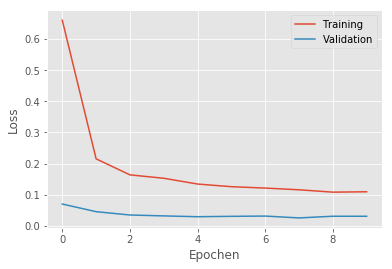

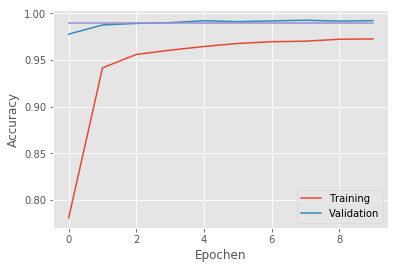

In [58]:
plt.figure(6)
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(7)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(hist3.history['acc'])
plt.plot(hist3.history['val_acc'])
prozent = np.full(10,0.99)
plt.plot(prozent)

plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

# Versuchvariante 2
* Kernelgröße vom ersten Conv Layer auf 5 mal 5 vergrößert

In [62]:
# ------------------------------------------------------------
# Netz 3: - Convolutional_NN mit 3 Conv-Layern + 2 Dense-Layern
#         - ReLu-Aktivierungsfunktion
#         - Dropout-Layer
# ------------------------------------------------------------

model = Sequential()

# -----------------------------------------------------------------------------------------
# Feature-Extractor
# -----------------------------------------------------------------------------------------
model.add(Conv2D(filters=32,      
                 kernel_size=(5, 5),   # alt kernel_size=(5, 5)
                 padding='valid', 
                 input_shape = shape_ord))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.4))


model.add(Conv2D(filters=64, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.4))


model.add(Conv2D(filters=128, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.6))

    
model.add(Flatten())

# -----------------------------------------------------------------------------------------
# Classifier
# -----------------------------------------------------------------------------------------

model.add(Dense(units=128))
model.add(Activation('relu'))

model.add(Dropout(0.7))

model.add(Dense(units=10))
model.add(Activation('softmax'))

In [63]:
# Übersicht über das Faltungsnetzwerk und die Parameter
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
activation_54 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_55 (Activation)   (None, 10, 10, 64)        0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 5, 5, 64)          0         
__________

In [64]:
model.compile(loss     =  'categorical_crossentropy',
              optimizer=  'adam',
              metrics  =  ['accuracy'])



hist3 = model.fit(X_train, Y_train, 
                  batch_size = 32, 
                  epochs     = 10,   # ohne GPU nicht mehr als 4, sonst wartet man seeehr lange.
                  verbose    = 1,
                  validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 175us/step - loss: 0.7513 - acc: 0.7533 - val_loss: 0.0964 - val_acc: 0.9737
Epoch 2/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.2758 - acc: 0.9243 - val_loss: 0.0685 - val_acc: 0.9792
Epoch 3/10
60000/60000 [==============================] - 10s 161us/step - loss: 0.2254 - acc: 0.9383 - val_loss: 0.0535 - val_acc: 0.9845
Epoch 4/10
60000/60000 [==============================] - 10s 163us/step - loss: 0.1958 - acc: 0.9487 - val_loss: 0.0435 - val_acc: 0.9873
Epoch 5/10
60000/60000 [==============================] - 10s 162us/step - loss: 0.1812 - acc: 0.9519 - val_loss: 0.0446 - val_acc: 0.9869
Epoch 6/10
60000/60000 [==============================] - 10s 161us/step - loss: 0.1703 - acc: 0.9560 - val_loss: 0.0415 - val_acc: 0.9879
Epoch 7/10
60000/60000 [==============================] - 10s 162us/step - loss: 0.1620 - acc: 0.9572 - val_loss: 0.

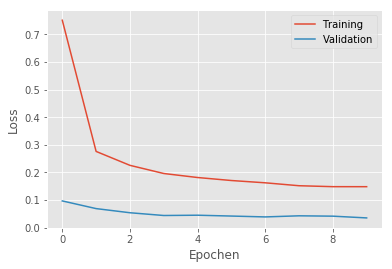

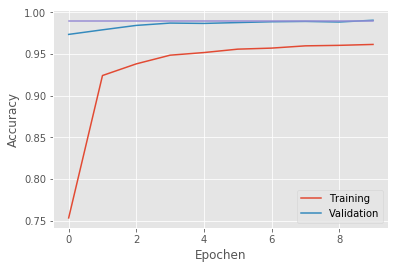

In [65]:
plt.figure(6)
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(7)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(hist3.history['acc'])
plt.plot(hist3.history['val_acc'])
prozent = np.full(10,0.99)
plt.plot(prozent)

plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

# Versuchsvariante 3
* Filteranzahl beim ersten Layer verdoppelt

In [66]:
# ------------------------------------------------------------
# Netz 3: - Convolutional_NN mit 3 Conv-Layern + 2 Dense-Layern
#         - ReLu-Aktivierungsfunktion
#         - Dropout-Layer
# ------------------------------------------------------------

model = Sequential()

# -----------------------------------------------------------------------------------------
# Feature-Extractor
# -----------------------------------------------------------------------------------------
model.add(Conv2D(filters=64,      
                 kernel_size=(3, 3),   # alt kernel_size=(5, 5)
                 padding='valid', 
                 input_shape = shape_ord))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.4))


model.add(Conv2D(filters=64, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.4))


model.add(Conv2D(filters=128, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.6))

    
model.add(Flatten())

# -----------------------------------------------------------------------------------------
# Classifier
# -----------------------------------------------------------------------------------------

model.add(Dense(units=128))
model.add(Activation('relu'))

model.add(Dropout(0.7))

model.add(Dense(units=10))
model.add(Activation('softmax'))

In [68]:
# Übersicht über das Faltungsnetzwerk und die Parameter
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
activation_59 (Activation)   (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
activation_60 (Activation)   (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 5, 5, 64)          0         
__________

In [69]:
model.compile(loss     =  'categorical_crossentropy',
              optimizer=  'adam',
              metrics  =  ['accuracy'])



hist3 = model.fit(X_train, Y_train, 
                  batch_size = 32, 
                  epochs     = 10,   # ohne GPU nicht mehr als 4, sonst wartet man seeehr lange.
                  verbose    = 1,
                  validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 175us/step - loss: 0.7602 - acc: 0.7530 - val_loss: 0.1177 - val_acc: 0.9651
Epoch 2/10
60000/60000 [==============================] - 10s 163us/step - loss: 0.3017 - acc: 0.9176 - val_loss: 0.0886 - val_acc: 0.9757
Epoch 3/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.2458 - acc: 0.9338 - val_loss: 0.0742 - val_acc: 0.9790
Epoch 4/10
60000/60000 [==============================] - 10s 162us/step - loss: 0.2225 - acc: 0.9421 - val_loss: 0.0688 - val_acc: 0.9812
Epoch 5/10
60000/60000 [==============================] - 10s 161us/step - loss: 0.2093 - acc: 0.9460 - val_loss: 0.0656 - val_acc: 0.9823
Epoch 6/10
60000/60000 [==============================] - 9s 158us/step - loss: 0.1942 - acc: 0.9496 - val_loss: 0.0580 - val_acc: 0.9847
Epoch 7/10
60000/60000 [==============================] - 10s 161us/step - loss: 0.1883 - acc: 0.9509 - val_loss: 0.0

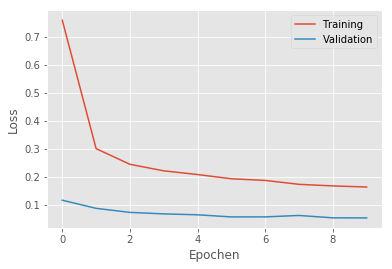

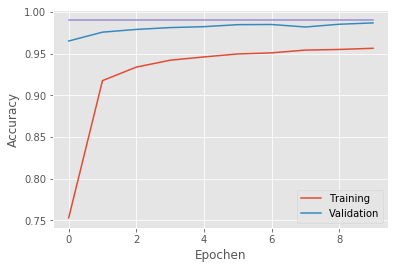

In [70]:
plt.figure(6)
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.legend(['Training', 'Validation'])

plt.figure(7)
plt.xlabel('Epochen')
plt.ylabel('Accuracy')
plt.plot(hist3.history['acc'])
plt.plot(hist3.history['val_acc'])
prozent = np.full(10,0.99)
plt.plot(prozent)
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()

### Fehleranalyse
1. Anzeigen einiger Fehlklassifikationen
2. Confusion-Matrix (= wer wird mit wem verwechselt?)

In [33]:
# Die erkannten Klassen der Testdaten bestimmen.
predicted_classes = model.predict_classes(X_test)

# Die Indices der richtig und falsch erkannten Muster bestimmen
correct   = np.nonzero(predicted_classes == y_test_ori)[0]     # nonzero:  Return the indices of array-
incorrect = np.nonzero(predicted_classes != y_test_ori)[0]     #           elements that are non-zero ()

In [49]:
# predicted_classes[40:45]
# y_test_ori[40:45]
# np.nonzero(predicted_classes == y_test_ori)[0].shape
np.nonzero(predicted_classes != y_test_ori)[0].size

112

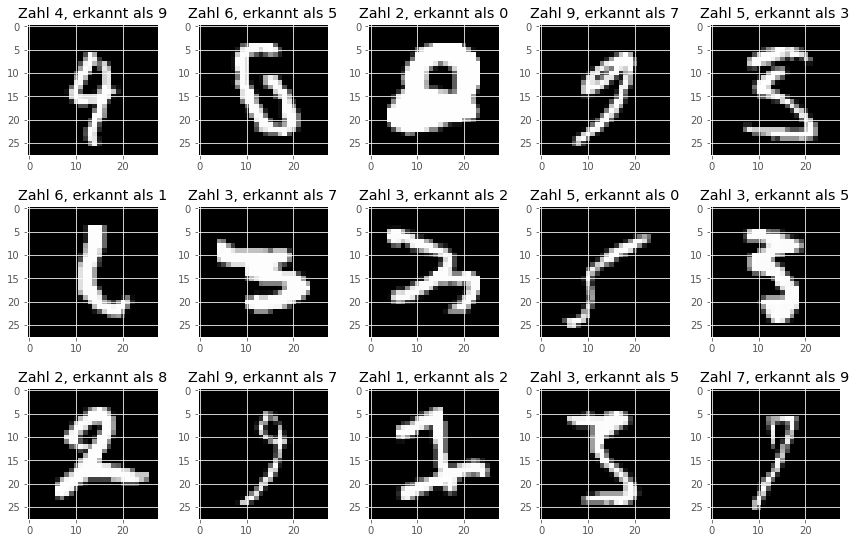

In [34]:
start                = 40    # Startindex

plt.figure(8)
plt.figure(figsize   = (12,8))
           
for i, incorr in enumerate(incorrect[start:start+15]):
    #print(i, incorr)
    plt.subplot(3,5,i+1)
    plt.imshow(X_test[incorr].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Zahl {}, erkannt als {}".format(y_test_ori[incorr], predicted_classes[incorr]))
    plt.tight_layout()

In [35]:
# Die Confusion-Matrix zeigt an, wie oft ein Zeichen
# für ein anderes Zeichen gehalten wird.
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test_ori, predicted_classes))

[[ 978    0    0    0    0    0    1    1    0    0]
 [   0 1132    1    0    0    0    1    1    0    0]
 [   2    0 1016    0    1    0    0   11    2    0]
 [   0    0    3  983    0   10    0   12    1    1]
 [   1    0    0    0  971    0    3    0    0    7]
 [   4    0    0    1    0  884    1    2    0    0]
 [   2    2    0    0    1    2  950    0    1    0]
 [   0    4    5    0    0    1    0 1016    0    2]
 [   1    0    1    0    2    1    1    1  966    1]
 [   4    0    0    0    4    1    0    6    2  992]]
